In [50]:
from src.utils.results_utils import *
from src.utils.data_utils import str_dict_to_values
from src.utils.ml_utils import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

## Load and clean the dataset

In [51]:
df_ml = pd.read_csv('data/cleaned.csv')
df_ml['Country'] = df_ml['Country'].apply(str_dict_to_values)
df_ml['Genres'] = df_ml['Genres'].apply(str_dict_to_values)


In [52]:
df_ml.drop(columns=['Wikipedia_ID','Name','Languages','Release_date'],inplace=True)
df_ml.head()

,Country,Genres,Character_name,Sex,Actor_age
0,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,F,42.0
1,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Melanie,F,27.0
2,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Williams,M,32.0
3,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Jericho,M,33.0
4,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Bashira,F,23.0


In [53]:
get_vowel_stats(df_ml, 'Character_name')
df_ml.head()

,Country,Genres,Character_name,Sex,Actor_age,vowel_count,consonant_count,name_length
0,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,F,42.0,5,3,8
1,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Melanie,F,27.0,4,3,7
2,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Williams,M,32.0,3,5,8
3,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Jericho,M,33.0,3,4,7
4,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Bashira,F,23.0,3,4,7


In [54]:
find_unusual_characters(df_ml,'Character_name')

Number of rows containing special characters: 2280
Unusual Characters Found: {'ï', 'å', 'ú', 'á', 'é', 'ó', 'è', 'ò', 'Þ', 'à', 'ö', 'Ô', 'Å', 'í', 'Â', 'â', 'À', 'š', 'ì', 'ã', 'É', 'Á', 'ō', 'ß', 'Ø', 'ù', 'æ', 'ñ', 'ū', '-', 'û', 'ä', 'ł', 'ü', 'ê', 'È', 'î', 'õ', 'Í', 'ý', 'Õ', 'Ó', 'ø', 'ô', 'ś', 'ç', 'ë', 'þ', 'ž', 'ð', 'Ö'}


In [55]:
def plot_special_character_distribution(df, column_name, allowed_chars='abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'):
    """
    Generate a Seaborn barplot showing the number of rows containing each type of special character.

    Parameters:
        df (pd.DataFrame): The dataset containing the column.
        column_name (str): The name of the column to analyze.
        allowed_chars (str): A string of allowed characters.
    """
    allowed_set = set(allowed_chars)
    
    # Initialize a counter for special characters
    special_char_counts = Counter()
    
    # Count special characters per row
    for value in df[column_name].dropna().astype(str):
        special_chars = set(value) - allowed_set
        special_char_counts.update(special_chars)
    
    # Convert to a DataFrame for plotting
    special_char_df = pd.DataFrame.from_dict(special_char_counts, orient='index', columns=['Count']).reset_index()
    special_char_df.columns = ['Special Character', 'Count']
    
    # Plot the distribution using Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(data=special_char_df, x='Special Character', y='Count')
    plt.title('Distribution of Special Characters')
    plt.xlabel('Special Character')
    plt.ylabel('Number of Rows Containing Character')
    plt.show()

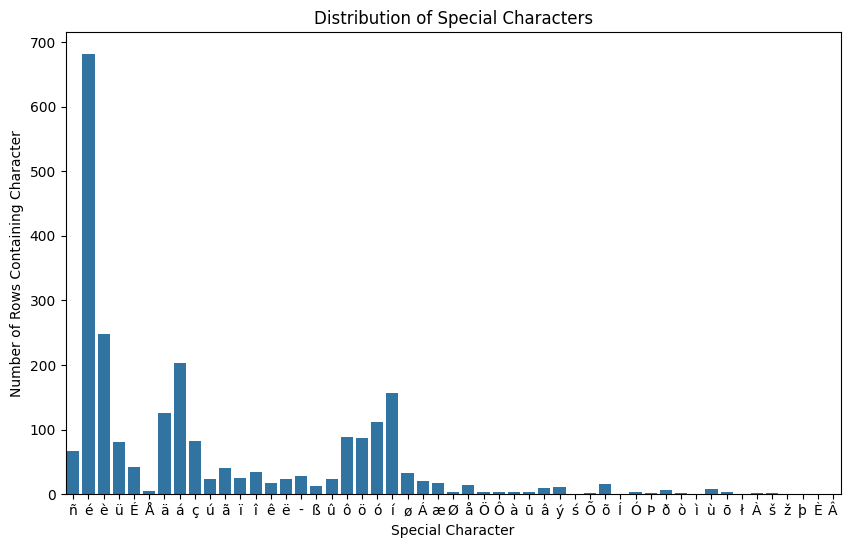

In [56]:
plot_special_character_distribution(df_ml,'Character_name')

We will add the most frequent special character to the alphabet: 'é', 'è', 'á' and 'í'

In [57]:
augmented_alphabet = 'abcdefghijklmnopqrstuvwxyzéèíá'

In [58]:
character_processor = NameFeatureProcessor('Character_name', ngram_range = (2,2))

df_ml = character_processor.process(df_ml,alphabet = augmented_alphabet,analyze_name = False, diacritic = False, phonetics = False, first_last = True, ngram=False)
df_ml.head()

,Country,Genres,Character_name,Sex,Actor_age,vowel_count,consonant_count,name_length,a_f,b_f,...,u_l,v_l,w_l,x_l,y_l,z_l,é_l,è_l,í_l,á_l
0,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,F,42.0,5,3,8,1,0,...,0,0,0,0,1,0,0,0,0,0
1,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Melanie,F,27.0,4,3,7,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Williams,M,32.0,3,5,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Jericho,M,33.0,3,4,7,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Bashira,F,23.0,3,4,7,0,1,...,0,0,0,0,0,0,0,0,0,0


In [59]:
vectorizer = HashingVectorizer(analyzer='char', ngram_range=(2, 3), n_features=100)  # Example: using 1024 features
ngram_features = vectorizer.fit_transform(df_ml['Character_name'])
n_gram_df = pd.DataFrame(ngram_features.toarray())
df_ml = pd.concat([df_ml, n_gram_df], axis=1)


## Gender Predictions

In [60]:
df_ml_gender = df_ml.drop(columns=['Country','Genres','Actor_age','Character_name'])
df_ml_gender.columns = df_ml_gender.columns.astype(str)

In [61]:
rows_with_nans = df_ml_gender.isna().any(axis=1).sum()
print(rows_with_nans)

5583


In [62]:
df_ml_gender = df_ml_gender.dropna()

In [63]:
# Divide Features and target
X_gender = df_ml_gender.drop(columns=['Sex'])
y_gender = df_ml_gender['Sex']

In [64]:
X_train, X_val, y_train, y_val = train_test_split(X_gender, y_gender, test_size=0.2, random_state=42)

In [65]:
X_train.head()

,vowel_count,consonant_count,name_length,a_f,b_f,c_f,d_f,e_f,f_f,g_f,...,90,91,92,93,94,95,96,97,98,99
38144,2,3,5,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102995,2,6,8,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7031,3,5,8,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4227,2,4,6,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87656,3,5,8,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(10,10,10,2),max_iter=500, random_state=42)
clf.fit(X_train,y_train)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(10, 10, 10, 2), max_iter=500,
              random_state=42)

In [67]:
y_pred = clf.predict(X_val)
accuracy_score(y_val,y_pred)

0.8553804418033846

In [68]:
with open('hashing_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)

In [84]:
def feature_creation(name):
    df_pred = pd.DataFrame([name], columns=['Name'])
    get_vowel_stats(df_pred,'Name')
    pred_processor = NameFeatureProcessor('Name',ngram_range=(2,2))
    df_pred =pred_processor.process(df_pred,alphabet = augmented_alphabet,analyze_name = False, diacritic = False, phonetics = False, first_last = True, ngram=False)

    with open('hashing_vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)
    ngram_name = vectorizer.transform(df_pred['Name'])
    ngram_name_df = pd.DataFrame(ngram_name.toarray())
    df_pred = pd.concat([df_pred, ngram_name_df], axis=1)
    return df_pred
    

,Name,vowel_count,consonant_count,name_length,a_f,b_f,c_f,d_f,e_f,f_f,...,90,91,92,93,94,95,96,97,98,99
0,Luca,2,2,4,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.447214,0.0,0.0


In [85]:
def predict(df):
    df.drop(columns=['Name'],inplace=True)
    df.columns = df.columns.astype(str)
    return clf.predict(df)

array(['F'], dtype='<U1')

In [86]:
def create_and_predict(name):
    df = feature_creation(name)
    pred = predict(df)
    print(pred)

In [96]:
create_and_predict('Henriette')

['F']
